# Style-Transfer with TensorFlow 2.0

## Primeros pasos 

Primero, se tienen que importar las bibliotecas necesarias. Para esto utilizaremos:
1. TensorFlow, para la red neuronal
2. matplotlib, para ver las imagenes
3. numpy, para los vectores

Para instalar estas librerias se puede utilizar el comando de abajo.

In [ ]:
!pip install tensorflow==2.0.0-alpha0 matplotlib numpy

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False


import numpy as np
import time

Esta es una funcion para cargar una imagen de un path en Tensorflow, lo carga como matrices para qe se pueda utilizar.

In [7]:
def load_img(path):
    max_dim=512
    img=tf.io.read_file(path)
    img=tf.image.decode_image(img, channels=3)
    img=tf.image.convert_image_dtype(img, tf.float32)
    
    shape=tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim=max(shape)
    scale=max_dim/long_dim
    
    new_shape = tf.cast(shape*scale, tf.int32)
    img=tf.image.resize(img, new_shape)
    img=img[tf.newaxis,:]
    return img

Esta es una funcion para ver las imagenes, utiliza matplotlib para "graficarlas".

In [9]:
def show_img(image, title=None):
    if len(image.shape)>3:
        image = tf.squeeze(image,axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

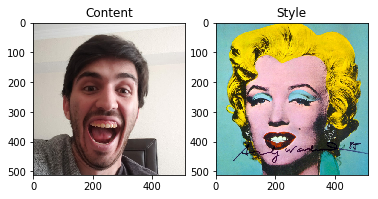

In [11]:
cont_img=load_img('selfie_dan.jpeg')
style_img=load_img('styles/van_gough.jpg')

plt.subplot(1,2,1)
show_img(cont_img, 'Content')

plt.subplot(1,2,2)
show_img(style_img, 'Style')

## Red neuronal

Aqui, se esta utilizando un tipo de red llamada VGG19, pre entrenada con los pesos de imagenet de Google. Hacerlo pre entrenada va a hacer que no se tenga que entrenar tanto tiempo.

In [21]:
x = tf.keras.applications.vgg19.preprocess_input(cont_img*255)
x = tf.image.resize(x, (224,224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
r=vgg(x)
print()
for layer in vgg.layers:
  print(layer.name)


input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


In [19]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
print(imagenet_labels[np.argsort(r)[0,::-1][:5]+1])

['suit' 'seat belt' 'bow tie' 'Windsor tie' 'neck brace']


Anteriormente, habiamos utilizado la red neuronal con el clasificador de imagenes al final, por eso, esta vez solamente utilizaremos los pesos y el principio de la red neuronal. Esto se llama Transfer Learning.

In [20]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 10s 0us/step

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [22]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [23]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [26]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_img*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 512, 64)
  min:  0.0
  max:  813.3443
  mean:  37.073284

block2_conv1
  shape:  (1, 256, 256, 128)
  min:  0.0
  max:  4613.0786
  mean:  180.81285

block3_conv1
  shape:  (1, 128, 128, 256)
  min:  0.0
  max:  9249.225
  mean:  167.41602

block4_conv1
  shape:  (1, 64, 64, 512)
  min:  0.0
  max:  18904.684
  mean:  645.41016

block5_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  3005.1394
  mean:  52.26425



In [27]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [28]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [30]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(cont_img))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  69213.65
    mean:  318.21967

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  83692.44
    mean:  8995.479

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  223005.17
    mean:  7380.6523

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1776764.8
    mean:  116529.836

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  94553.516
    mean:  937.465

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  1111.8735
    mean:  11.116283


In [31]:
style_targets = extractor(style_img)['style']
content_targets = extractor(cont_img)['content']

In [32]:
image = tf.Variable(cont_img)

In [33]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [34]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [35]:
style_weight=1e-2
content_weight=1e4

In [36]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [37]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

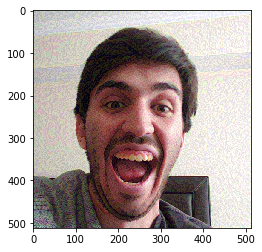

In [38]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

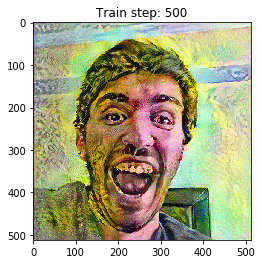

Epoch: 5
....................................................................................

KeyboardInterrupt: 

In [40]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    print('Epoch: {}'.format(n))
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    show_img(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))